In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')

from sklearn import datasets
import math
import numpy as np
from tqdm import tqdm
import torch
torch.manual_seed(1)
from torch.autograd import grad
from torch import nn, optim
import torch.nn.functional as F 
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
from datasets.Classification.TwoMoons import create_test_points, create_train_set

n_datapoints=1024
batch_size = 32
x, y = create_train_set(n_datapoints=n_datapoints, noise=0.2)
y = y.float()
train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size)

In [2]:
model = torch.nn.Sequential(nn.Linear(2, 100), nn.Tanh())
prediction_model = nn.Sequential(nn.Linear(100,1, bias=False), nn.Sigmoid())
optimizer = torch.optim.Adam(list(model.parameters()) + list(prediction_model.parameters()))
loss_fun = nn.BCELoss()

In [3]:
def compute_hessian(data, target):
    features = model(data)
    prediction = prediction_model(features)
    return ((prediction * (1-prediction))* features.square()).sum(dim=0)

def compute_hessian_ggn(data, target):
    features = model(data)
    prediction = prediction_model(features)
    error = prediction - target.unsqueeze(dim=-1)
    hessian = torch.square(error * features)
    return hessian.sum(dim=0)

def compute_hessian_ggn2(features, prediction, target):
    error = prediction - target.unsqueeze(dim=-1)
    hessian = torch.square(error * features)
    return hessian.sum(dim=0)

In [4]:
pbar = tqdm(range(200))
for epoch in pbar:
    for data, target in train_loader:
        optimizer.zero_grad()
        features = model(data)
        pred = prediction_model(features).squeeze(dim=-1)
        loss = loss_fun(pred, target)
        loss.backward(retain_graph=True)

        # hess = compute_hessian_ggn2(features, pred.unsqueeze(dim=-1), target)
        # hess_grad = 1000 * grad(hess.log().sum(), prediction_model[0].weight)[0]
        # prediction_model[0].weight.grad += hess_grad

        optimizer.step()
        # pbar.set_description(f"{loss.item()}")

100%|██████████| 200/200 [00:03<00:00, 58.58it/s]


In [5]:
hessian_approx = torch.zeros_like(prediction_model[0].weight)
with torch.no_grad():
    for data, target in train_loader:
        # hessian_approx+= compute_hessian_ggn(data, target)
        hessian_approx += compute_hessian(data, target)

cov = 1/hessian_approx.squeeze()
cov/=n_datapoints

In [9]:
n_test_datapoints = 100
X_test, X1_test, X2_test = create_test_points(-2, 3, n_test_datapoints)

with torch.no_grad():
    features = model(X_test)
    lik_mean = prediction_model(features)
    lik_cov = features @ cov.diag() @ torch.transpose(features, 0, 1)
    lik = lik_mean / torch.sqrt(1 + math.pi * lik_cov.diagonal() / 8)
    # lik = torch.distributions.MultivariateNormal(prediction_model(features), features @ cov.diag() @ torch.transpose(features, 0, 1)).sample(1).mean(dim=0)
lik = torch.cat((lik, (1-lik)), dim=-1)

In [7]:
with torch.no_grad():
    features = model(X_test)
    lik = prediction_model(features)
lik = torch.cat((lik, (1-lik)), dim=-1)

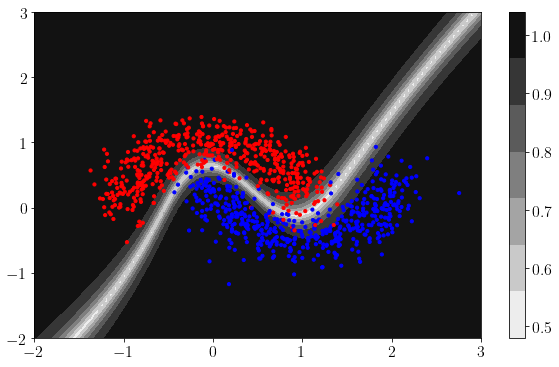

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
map_conf = lik.abs().max(1).values.reshape(n_test_datapoints, n_test_datapoints)
cax1 = ax.contourf(X1_test, X2_test, map_conf, cmap="binary")
cbar = fig.colorbar(cax1, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)
# plt.savefig("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/results/Classification/init_laplace/ll_train_only.jpg")
plt.show()
